In [52]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [53]:
!pip install keras;

In [54]:
!pip install tensorflow;

In [55]:
import numpy as np
import pandas as pd

from scipy.io import loadmat
from scipy.signal import butter, sosfiltfilt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.layers.advanced_activations import LeakyReLU
import tensorflow as td

import matplotlib.pyplot as plt
%matplotlib inline

In [56]:
eeg = loadmat('/content/drive/MyDrive/Colab Notebooks/datasets/WLDataAll.mat')

data = eeg['data']
labels = eeg['label']

print(data.shape)
print(labels.shape)

(62, 512, 360)
(1, 360)


In [57]:
def butter_bandpass_filter(data, lowcut = 0.1, highcut = 64, fs = 200, order=5):
    nyq = 0.5 * fs
    low = lowcut /nyq
    high = highcut/nyq
    sos = butter(order, [low, high], analog = False, btype='band', output='sos')
    filtered_data = sosfiltfilt(sos, data)
    return filtered_data

In [58]:
data = butter_bandpass_filter(data)
data.shape

(62, 512, 360)

In [59]:
idx = np.random.permutation(data.shape[2])
data,labels = data[:, :, idx], labels[:, idx]
print(data.shape)
print(labels.shape)

(62, 512, 360)
(1, 360)


In [60]:
labels[labels == 1] = 0
labels[labels == 2] = 1

data = data.transpose(2,0,1)
data.shape

(360, 62, 512)

In [61]:
minimumvalue = np.amin(data)
data = data+ abs(minimumvalue) + 1

In [62]:
X_train = data[:216,:,:]
y_train = labels[0,:216]
X_valid = data[216:288,:,:]
y_valid = labels[0,216:288]
X_test = data[288:,:,:]
y_test = labels[0,288:]

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[0]).T).T.reshape(X_train.shape)
X_valid = scaler.transform(X_valid.reshape(-1, X_valid.shape[0]).T).T.reshape(X_valid.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[0]).T).T.reshape(X_test.shape)

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(216, 62, 512)
(216,)
(72, 62, 512)
(72,)
(72, 62, 512)
(72,)


In [63]:
X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')
X_test = X_test.astype('float32')

In [64]:
print(np.unique(y_train),
np.unique(y_valid),
np.unique(y_test))

[0 1] [0 1] [0 1]


In [65]:
batch_size = 64
epochs = 10
num_classes = 1

In [66]:
model = Sequential()
model.add(Conv1D(32, 3, activation='relu', input_shape=(62,512)))
model.add(MaxPooling1D(2))
model.add(Dropout(0.25))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.25))
model.add(Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.25))
model.add(Conv1D(128, (3), activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 60, 32)            49184     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 30, 32)            0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 30, 32)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 28, 64)            6208      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 14, 64)            0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 14, 64)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 12, 128)          

In [67]:
model.compile(loss=keras.losses.binary_crossentropy, optimizer=td.keras.optimizers.Adam(),metrics=['accuracy'])

In [68]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 60, 32)            49184     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 30, 32)            0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 30, 32)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 28, 64)            6208      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 14, 64)            0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 14, 64)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 12, 128)          

In [69]:
trained_model = model.fit(X_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_valid, y_valid))

Epoch 1/10
4/4 [==============================] - 1s 105ms/step - loss: 0.7278 - accuracy: 0.5231 - val_loss: 0.6845 - val_accuracy: 0.5556
Epoch 2/10
4/4 [==============================] - 0s 24ms/step - loss: 0.7052 - accuracy: 0.4907 - val_loss: 0.6838 - val_accuracy: 0.5417
Epoch 3/10
4/4 [==============================] - 0s 22ms/step - loss: 0.6922 - accuracy: 0.4769 - val_loss: 0.6825 - val_accuracy: 0.5694
Epoch 4/10
4/4 [==============================] - 0s 21ms/step - loss: 0.6981 - accuracy: 0.4954 - val_loss: 0.6801 - val_accuracy: 0.6389
Epoch 5/10
4/4 [==============================] - 0s 21ms/step - loss: 0.6889 - accuracy: 0.5741 - val_loss: 0.6769 - val_accuracy: 0.6389
Epoch 6/10
4/4 [==============================] - 0s 24ms/step - loss: 0.6911 - accuracy: 0.5370 - val_loss: 0.6730 - val_accuracy: 0.5556
Epoch 7/10
4/4 [==============================] - 0s 21ms/step - loss: 0.6927 - accuracy: 0.5231 - val_loss: 0.6678 - val_accuracy: 0.5972
Epoch 8/10
4/4 [==========

In [70]:
test_eval = model.evaluate(X_test, y_test, verbose=0)

In [71]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.6751568913459778
Test accuracy: 0.5277777910232544


In [72]:
trained_model.history

{'accuracy': [0.5231481194496155,
  0.49074074625968933,
  0.47685185074806213,
  0.49537035822868347,
  0.5740740895271301,
  0.5370370149612427,
  0.5231481194496155,
  0.5231481194496155,
  0.5509259104728699,
  0.6018518805503845],
 'loss': [0.727843165397644,
  0.7052430510520935,
  0.6922377347946167,
  0.698080837726593,
  0.688901960849762,
  0.6911043524742126,
  0.6926628351211548,
  0.6854235529899597,
  0.6873835921287537,
  0.6812854409217834],
 'val_accuracy': [0.5555555820465088,
  0.5416666865348816,
  0.5694444179534912,
  0.6388888955116272,
  0.6388888955116272,
  0.5555555820465088,
  0.5972222089767456,
  0.5972222089767456,
  0.625,
  0.6666666865348816],
 'val_loss': [0.6845247745513916,
  0.6837589740753174,
  0.6825400590896606,
  0.6801180243492126,
  0.6769415736198425,
  0.6730165481567383,
  0.6677569150924683,
  0.6573585867881775,
  0.6504520177841187,
  0.6489463448524475]}

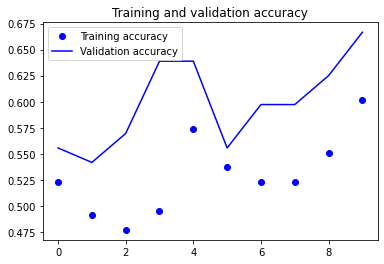

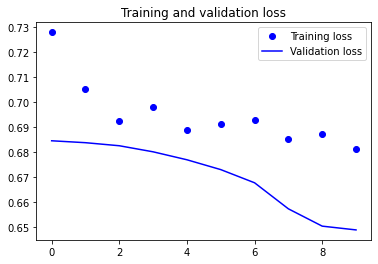

In [73]:
accuracy = trained_model.history['accuracy']
val_accuracy = trained_model.history['val_accuracy']
loss = trained_model.history['loss']
val_loss = trained_model.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()